# <center> Heart Disease Prediction Using SVM

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# Loading the data

In [2]:
#Loading the CSV file
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# EDA

In [3]:
def data_explore(dataframe):
    print("DATA EXPLORATION")
    print('*'*70)
    print("Shape of dataset : ",dataframe.shape)
    print('*'*70)
    print(dataframe.info())
    print('*'*70)
    print("STATISTICAL ANALYSIS OF NUMERICAL DATA")
    print('*'*70)
    print(dataframe.describe().T)
    print('*'*70)
    print("STATISTICAL ANALYSIS OF CATEGORICAL DATA")
    print('*'*70)
    print(dataframe.describe(exclude = ['float', 'int64']).T)
    print('*'*70)
    print("MISSING VALUES")
    print('*'*70)
    print(dataframe.isna().sum().sort_values(ascending=False))
    print('*'*70)
    print("MISSING VALUES IN %")
    print('*'*70)
    print(round(100* (dataframe.isnull().sum() / len(dataframe)).sort_values(ascending=False),2))
    print('*'*70)

In [4]:
#Exploring the data
data_explore(df)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (918, 12)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
********

In [5]:
#Extracting the categorical columns
cat_cols = [col for col in df.columns if df[col].dtypes =='O']

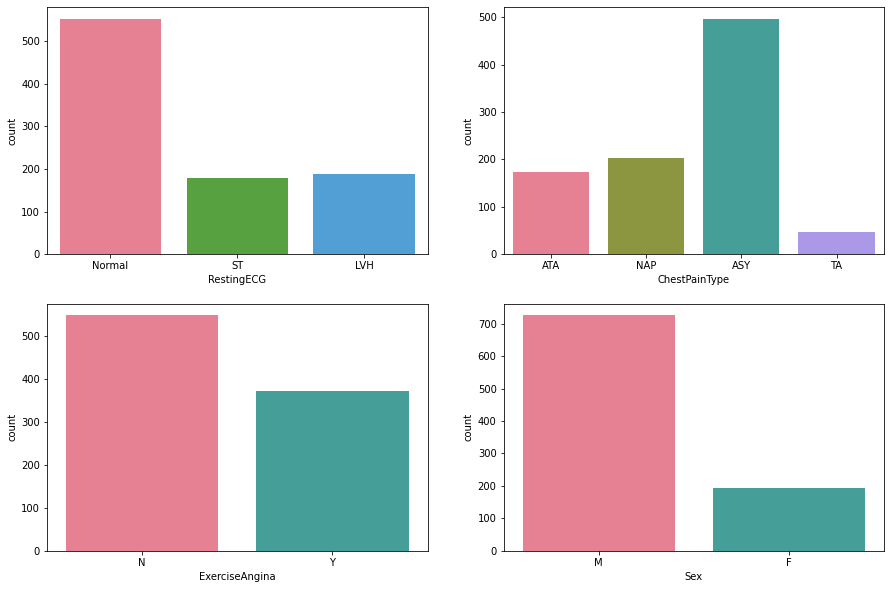

In [6]:
#Plotting the categorical variables on the target
fig, axes = plt.subplots(2, 2, figsize=(15,10))

#sns.countplot(x = df['HeartDisease'], data = df, palette='husl', ax=axes[0,0])
sns.countplot(x = df['RestingECG'], data = df, palette='husl', ax=axes[0,0])
sns.countplot(x = df['ChestPainType'], data = df, palette='husl', ax=axes[0,1])

sns.countplot(x = df['ExerciseAngina'], data = df, palette='husl', ax=axes[1,0])
sns.countplot(x = df['Sex'], data = df, palette='husl', ax=axes[1,1])
plt.show()

In [7]:
#Extracting the numerical columns
num_col = [feature for feature in df.columns if df[feature].dtypes != 'O']

<AxesSubplot:>

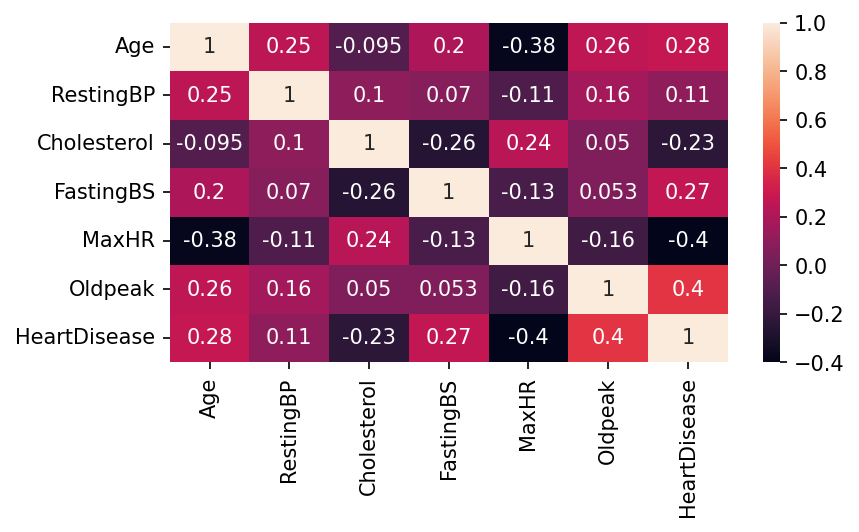

In [8]:
#Plotting a heatmap on the correlation values
plt.figure(figsize=(6,3), dpi=150)
sns.heatmap(df.corr(), annot=True)

In [9]:
#Finding the best correlation with the 'HeartDisease' column 
df.corr()['HeartDisease'].sort_values(ascending=False)

HeartDisease    1.000000
Oldpeak         0.403951
Age             0.282039
FastingBS       0.267291
RestingBP       0.107589
Cholesterol    -0.232741
MaxHR          -0.400421
Name: HeartDisease, dtype: float64

## Plotting the distributions of the numerical variables

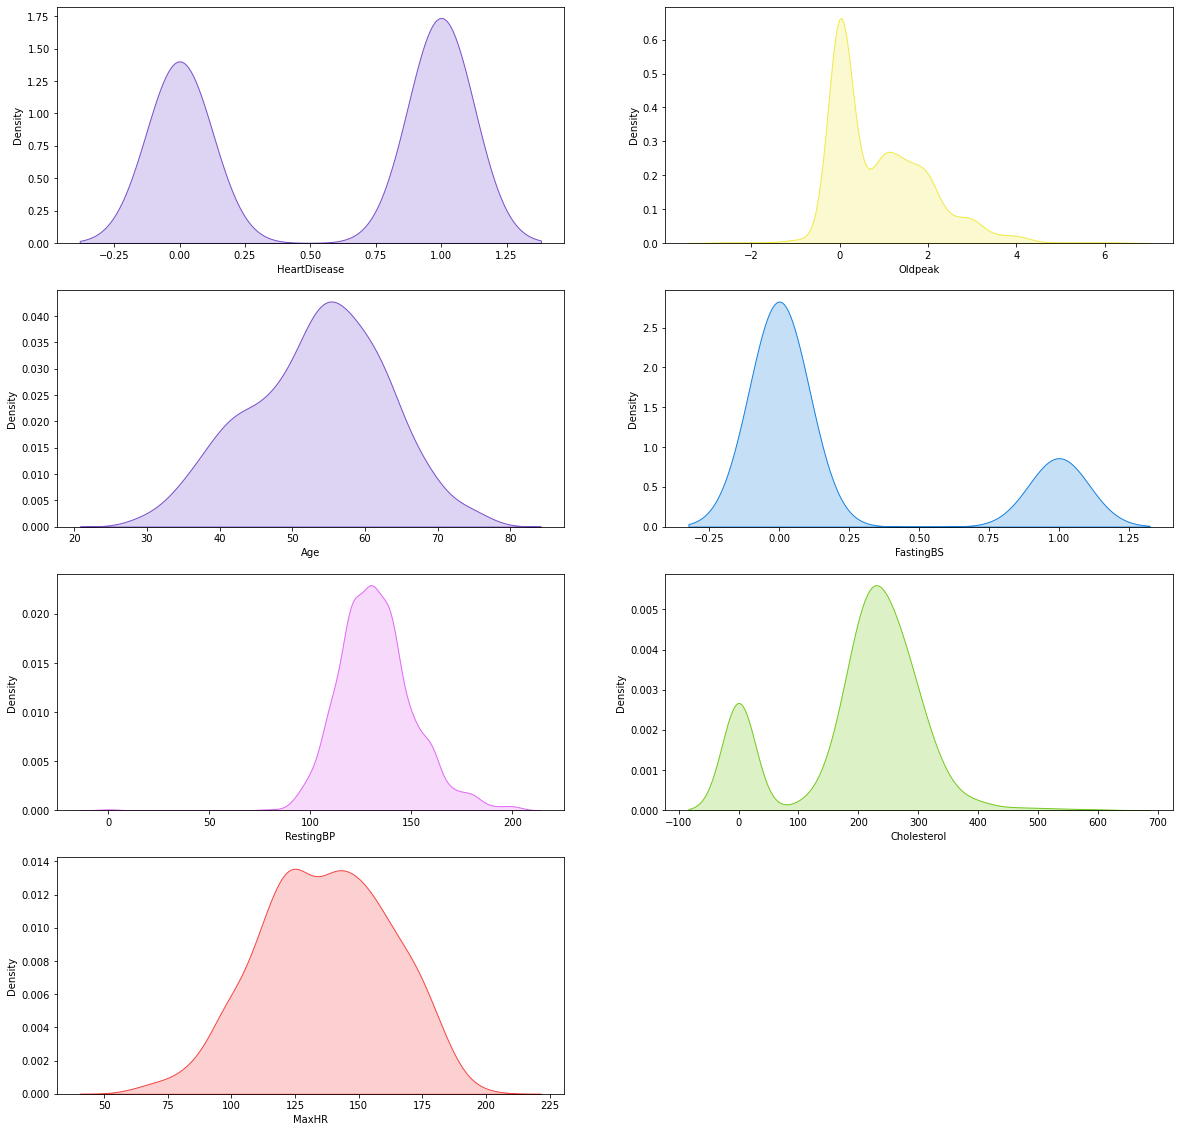

In [10]:
#Plotting the distributions of the numerical variables
color_plot = ['#de972c','#74c91e','#1681de','#e069f5','#f54545','#f0ea46','#7950cc']

fig,ax = plt.subplots(4,2,figsize=(20,20))
sns.kdeplot(df['HeartDisease'],color=np.random.choice(color_plot), ax=ax[0][0], shade=True)
sns.kdeplot(df['Oldpeak'],color=np.random.choice(color_plot), ax=ax[0][1], shade=True)
sns.kdeplot(df['Age'],color=np.random.choice(color_plot), ax=ax[1][0], shade=True)
sns.kdeplot(df['FastingBS'],color=np.random.choice(color_plot), ax=ax[1][1], shade=True)
sns.kdeplot(df['RestingBP'],color=np.random.choice(color_plot), ax=ax[2][0],shade=True)
sns.kdeplot(df['Cholesterol'],color=np.random.choice(color_plot), ax=ax[2][1], shade=True)
sns.kdeplot(df['MaxHR'],color=np.random.choice(color_plot), ax=ax[3][0],shade=True)
fig.delaxes(ax[3][1])


In [11]:
#Encoding the features using get dummies method
df=pd.get_dummies(df)

# Building the model

In [12]:
#Preparing the dataset for training
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix,classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV

In [14]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [15]:
#Scaling the features using pipeline
pipeline = Pipeline([
            ('std_scaler',StandardScaler()),
                    ])
scaled_X_train = pipeline.fit_transform(X_train)
scaled_X_test = pipeline.transform(X_test)

# Support Vector Classifier(with default parameters)

A support-vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin, the lower the generalization error of the classifier.

![](https://blog.paperspace.com/content/images/2020/03/svm.png)

In [16]:
#Fitting the model on SVC with default parameters
model_svc = SVC()
model_svc.fit(scaled_X_train,y_train)

SVC()

#### Checking the default parameters in an SVC

In [17]:
model_svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [18]:
#Calculating predictions, and accuracy score
pred_svc = model_svc.predict(scaled_X_test)
accuracy_score(y_test,pred_svc)

0.8840579710144928

In [19]:
#Building classification report
print(classification_report(y_test,pred_svc))

              precision    recall  f1-score   support

           0       0.91      0.82      0.87       125
           1       0.87      0.93      0.90       151

    accuracy                           0.88       276
   macro avg       0.89      0.88      0.88       276
weighted avg       0.89      0.88      0.88       276



#### We get an accuracy of 88.4% without tuning the hyperparameters. So let's try tuning the hyperparameters and check if it improves our accuracy

# Hyperparameter Tuning with GridSearchCV

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

In [20]:
#Hyperparamter tuning using Gridsearch
svm = SVC()
# param_grid = {'C':[0.01,0.05,0.1,1,10, 100, 1000],'kernel':['linear','rbf'], 'gamma':['scale','auto'] }
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
grid = GridSearchCV(svm,param_grid)

In [21]:
#Fitting the model
grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']})

In [22]:
#Calculating the accuracy of tuned model
grid_svc = grid.predict(scaled_X_test)
accuracy_score(y_test,grid_svc)

0.8913043478260869

In [23]:
#Classification report for the tuned model
print(classification_report(y_test,grid_svc))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       125
           1       0.90      0.91      0.90       151

    accuracy                           0.89       276
   macro avg       0.89      0.89      0.89       276
weighted avg       0.89      0.89      0.89       276



#### We get an accuracy of 89.13% with hyperparameter tuning, accounting for 0.7% increase in accuracy

# Best Parameters

In [24]:

print(grid.best_params_)
print(grid.best_estimator_.get_params())

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


#### The best parameters in this model is:
#### C=100 , gamma = 0.001, kernel: rbf